In [2]:
import os 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
plays = pd.read_csv('plays.csv')
players = pd.read_csv('players.csv')
playerplay = pd.read_csv('player_play.csv')
tracking_data = pd.read_csv('tracking_week_1.csv')

In [4]:
playerposition = players[['nflId','position']]

In [5]:
filteredtrack = tracking_data[['gameId','playId','frameId','nflId','displayName','x','y','event']]

In [6]:
filteredtrack = pd.merge(
    filteredtrack,
    playerposition,
    how='left',
    left_on=['nflId'],
    right_on=['nflId']
)

In [7]:
filteredtrack = filteredtrack[(filteredtrack['position']=="WR") | (filteredtrack['position']=="TE") | (filteredtrack['position']=="RB")]

In [9]:
motionplayers = playerplay[playerplay['motionSinceLineset']==True]

In [11]:
positions = players[['nflId','position']]

In [12]:
motionplayers = pd.merge(
    motionplayers,
    positions,
    how = "left",
    left_on=['nflId'],
    right_on=['nflId']
)

In [13]:
motionplayers = motionplayers[(motionplayers['position']=="WR") | (motionplayers['position']=="TE") | (motionplayers['position']=="RB")]

In [15]:
motiontracking = pd.merge(
    filteredtrack,
    motionplayers[['gameId','playId','nflId','motionSinceLineset','inMotionAtBallSnap']],
    how="inner",
    left_on=['gameId','playId','nflId'],
    right_on=['gameId','playId','nflId']
)

In [17]:
def filter_motion_to_snap(group):
    group = group.sort_values(by='frameId').reset_index(drop=True)
    line_set_indices = group[group['event'] == 'line_set'].index
    snap_indices = group[group['event'] == 'ball_snap'].index
    
    filtered_rows = []
    for start_idx in line_set_indices:
        snap_idx = snap_indices[snap_indices > start_idx].min()
        if pd.notna(snap_idx):
            filtered_rows.extend(group.loc[start_idx:snap_idx].index)
    return group.loc[filtered_rows]
filtered_df = motiontracking.groupby(['gameId', 'playId']).apply(filter_motion_to_snap).reset_index(drop=True)

In [19]:
filtered_df[['gameId','playId']].drop_duplicates().shape

(1076, 2)

In [20]:
motionstats = filtered_df.groupby(['gameId', 'playId', 'nflId'])['y'].agg(['first', 'last', 'max', 'min']).reset_index()

In [22]:
motionstats['direction_change'] = np.where((motionstats['last'] > motionstats['first']) & (motionstats['max'] > (motionstats['last'] + 1)),
    True,
    np.where((motionstats['last'] <= motionstats['first']) & (motionstats['min'] < (motionstats['last'] - 1)),True,False)
)


In [24]:
motionstats = pd.merge(
    motionstats,
    playerplay[['gameId','playId','nflId','inMotionAtBallSnap']],
    how="left",
    left_on=['gameId','playId','nflId'],
    right_on=['gameId','playId','nflId']
)

In [26]:
motion = motionstats[['first','last','direction_change','inMotionAtBallSnap']]

In [27]:
motion['direction_change'] = motion['direction_change'].astype(int)
motion['inMotionAtBallSnap'] = motion['inMotionAtBallSnap'].astype(int)

scaler = StandardScaler()
motion_scaled = scaler.fit_transform(motion)
kmeans = KMeans(n_clusters=5, random_state=0)
motion['cluster'] = kmeans.fit_predict(motion_scaled)
motion = pd.concat([motionstats[['gameId', 'playId', 'nflId']], motion], axis=1)

motion

C:\Users\bhaga\AppData\Local\Temp\ipykernel_4648\2091485017.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  motion['direction_change'] = motion['direction_change'].astype(int)
C:\Users\bhaga\AppData\Local\Temp\ipykernel_4648\2091485017.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  motion['inMotionAtBallSnap'] = motion['inMotionAtBallSnap'].astype(int)
c:\Users\bhaga\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_ini

,gameId,playId,nflId,first,last,direction_change,inMotionAtBallSnap,cluster
0,2022090800,56,42489.0,27.91,43.65,0,0,1
1,2022090800,80,47857.0,39.38,31.54,1,1,3
2,2022090800,212,47879.0,23.83,32.83,0,1,4
3,2022090800,236,52536.0,40.09,35.27,0,1,4
4,2022090800,299,43399.0,23.81,18.99,0,0,2
...,...,...,...,...,...,...,...,...
1328,2022091200,3382,46109.0,29.27,33.27,0,1,4
1329,2022091200,3491,46096.0,20.99,27.25,0,1,0
1330,2022091200,3553,52423.0,33.44,28.83,0,1,4
1331,2022091200,3596,52423.0,34.88,16.78,0,1,4


In [37]:
motion.to_csv('week1motion.csv',index=False)

In [33]:
motion[['min','max']] = motionstats[['min','max']]

In [36]:
cluster_means = motion.groupby('cluster').agg(
    first_mean=('first', 'mean'),
    last_mean=('last', 'mean'),
    direction_change_mean=('direction_change', 'mean'),
    move_at_snap_mean=('inMotionAtBallSnap','mean'),
    count=('first', 'size')
)

cluster_means

,first_mean,last_mean,direction_change_mean,move_at_snap_mean,count
cluster,,,,,
0,19.314062,23.728854,0.0,1.000000,288
1,30.533132,34.589537,0.0,0.000000,281
2,24.523716,21.749829,0.0,0.000000,409
3,28.496667,26.707564,1.0,0.602564,78
4,35.197292,30.062383,0.0,1.000000,277


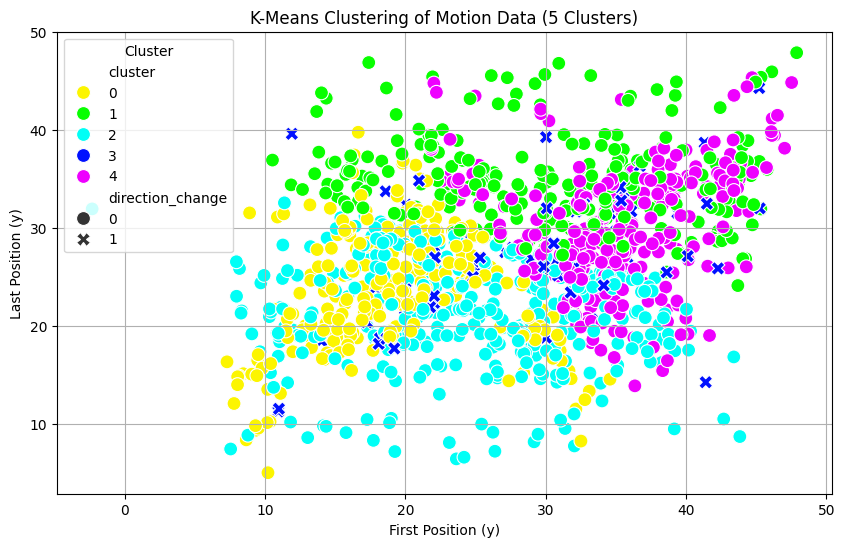

In [30]:
palette = sns.color_palette("hsv", n_colors=5)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=motion,
    x='first', 
    y='last', 
    hue='cluster', 
    palette=palette,
    style='direction_change', # Different markers for direction change
    s=100, # Adjust marker size
    legend="full"
)

plt.title("K-Means Clustering of Motion Data (5 Clusters)")
plt.xlabel("First Position (y)")
plt.ylabel("Last Position (y)")
plt.legend(title="Cluster", loc="best")
plt.grid(True)
plt.show()